# Playground Script
### -- Moritz

### Libraries

In [7]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.utils import draw_segmentation_masks
from torchvision.ops import masks_to_boxes
import torchvision.transforms.functional as F

import ultralytics
from ultralytics import YOLO
from ultralytics import settings

In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

### Notes

- Train test split:
    - Split: 70 / 20 / 10
    - => 1780 + 508 + 254 images and labels in train/test/split

### Draw Bounding Boxes

In [9]:
# Read in an image and its mask
IMAGE_DIRECTORY = "data/kasmi_solar/bdappv/google"

img_path = os.path.join(IMAGE_DIRECTORY, "img/AAKEG5A92ACPSX.png")
mask_path = os.path.join(IMAGE_DIRECTORY, "mask/AAKEG5A92ACPSX.png")

img = read_image(img_path, mode=ImageReadMode.RGB)
mask = read_image(mask_path, mode=ImageReadMode.GRAY)

torch.Size([3, 400, 400])
torch.Size([1, 400, 400])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


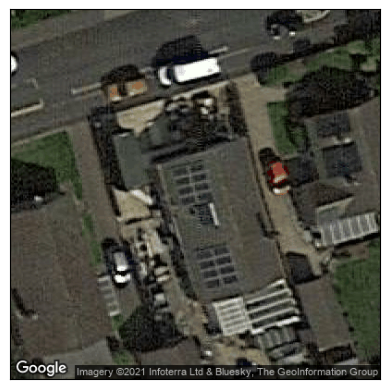

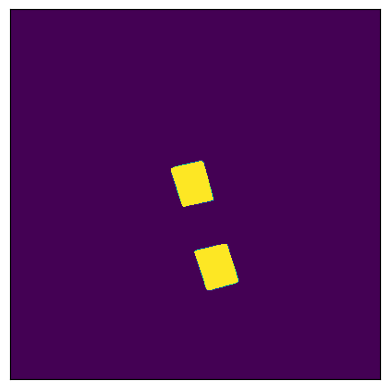

In [10]:
print(img.size())
print(mask.size())
print(mask)

show(img)
show(mask)

In [11]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks = mask == obj_ids[:, None, None]

In [12]:
print(masks.size())
print(masks)

torch.Size([1, 400, 400])
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])


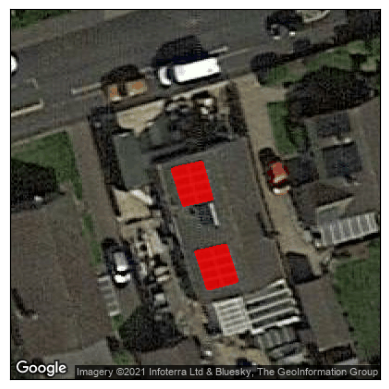

In [13]:
drawn_mask = draw_segmentation_masks(img, masks, alpha=0.8, colors="red")

show(drawn_mask)

### Convert Masks to Bounding Boxes

In [45]:
# Define image width and height
IMG_WIDTH = IMG_HEIGHT = 400

In [46]:
def bboxes_yolo(bbox):
    x_center = ((bbox[0] + bbox[2])/2) / IMG_WIDTH
    y_center = ((bbox[1] + bbox[3])/2) / IMG_HEIGHT
    box_width = (bbox[2] - bbox[0]) / IMG_WIDTH
    box_height = (bbox[3] - bbox[1]) / IMG_HEIGHT

    bbox_yolo = (x_center, y_center, box_width, box_height)
    return bbox_yolo

def bboxes_albumentations(bbox):
    bbox_normalized = np.empty(4, dtype="float")
    bbox_normalized[[1,3]] = bbox[[1,3]] / IMG_HEIGHT
    bbox_normalized[[0,2]] =  bbox[[0,2]] / IMG_WIDTH    
    return bbox_normalized

In [47]:
# Masks to bounding boxes
tensor_box = masks_to_boxes(mask)
box = tensor_box.numpy()[0] # transform to ndarray
box # (x1, y1, x2, y2) format

array([        174,         164,         246,         303], dtype=float32)

In [28]:
bbox_norm = bboxes_albumentations(box)
bbox_norm

array([     0.4475,      0.4125,       0.535,      0.5825])

In [29]:
bbox_yolo = bboxes_yolo(box)
bbox_yolo

(0.49125, 0.4975, 0.0875, 0.17)

In [31]:
mask_files = os.listdir("data/kasmi_solar/bdappv/google/mask/")

try:
    os.makedirs("data/kasmi_solar/bdappv/google/labels", exist_ok=False)
except OSError:
    pass

In [33]:
mask_files = os.listdir("data/kasmi_solar/bdappv/google/mask/")
try:
    os.makedirs("data/kasmi_solar/bdappv/google/labels", exist_ok=False)
except OSError:
    pass

for i in range(0, len(mask_files)):

    mask_path = "data/kasmi_solar/bdappv/google/mask/" + mask_files[i]
    mask = read_image(mask_path, mode=ImageReadMode.GRAY)

    tensor_box = masks_to_boxes(mask)
    box = tensor_box.numpy()[0] # transform to ndarray

    bbox_yolo = bboxes_yolo(box)

    class_label = "0"
    bbox_label = class_label + " " + ' '.join(map(str, bbox_yolo)) # add a class to the label

    picture_ID = str.strip(mask_files[i], ".png")
    label_path = "data/kasmi_solar/bdappv/google/labels/" + picture_ID + ".txt"
    with open(label_path, "w") as file:
        file.write(bbox_label)


### Separate Images with Solar Panels from Images w/o Panels

In [34]:
all_images = os.listdir("data/kasmi_solar/bdappv/google/img/")
images_with_masks = os.listdir("data/kasmi_solar/bdappv/google/mask/")
images_without_masks = [x for x in all_images if x not in images_with_masks]

len(images_without_masks + images_with_masks) == len(all_images)

True

In [318]:
source = "data/kasmi_solar/bdappv/google/img/"
destination = "data/kasmi_solar/bdappv/google/img_with_panels/"

try:
    os.makedirs(destination, exist_ok=False)
except OSError:
    pass

for i in images_with_masks:
    shutil.copy(source + i, destination)

### Train-Test Split

In [37]:
import random

source_path_imgs = "data/kasmi_solar/bdappv/google/img_with_panels/"
imgs_list = os.listdir(source_path_imgs)
img_ids = [str.rstrip(i, ".png") for i in imgs_list]

In [38]:
# Split up image IDs

from sklearn.model_selection import train_test_split

train_ids, test_and_val_ids = train_test_split(img_ids, test_size=0.3, random_state=42) # train 0.7, test+val 0.3
test_ids, val_ids = train_test_split(test_and_val_ids, test_size=0.5, random_state=42) # test 0.15, val 0.15

print(len(train_ids), len(test_ids), len(val_ids))
print(len(train_ids)+len(test_ids)+len(val_ids))

9312 1995 1996
13303


In [39]:
# Copy labels and images to their yolo-organized directories


origin_path = "data/kasmi_solar/bdappv/google/"
destination_path = "datasets/kasmi_solar/"

# path to destination folders
train_folder_imgs = os.path.join(destination_path, 'train/images')
test_folder_imgs = os.path.join(destination_path, 'test/images')
val_folder_imgs = os.path.join(destination_path, 'val/images')


# Move images to destination

for i in train_ids:
    shutil.copy(
        origin_path + "img_with_panels/" + i + ".png", 
        destination_path + "train/images/"
    )
for i in test_ids:
    shutil.copy(
        origin_path + "img_with_panels/" + i + ".png", 
        destination_path + "test/images/"
    )
for i in val_ids:
    shutil.copy(
        origin_path + "img_with_panels/" + i + ".png", 
        destination_path + "val/images/"
    )

# Move labels to destination
    
for i in train_ids:
    shutil.copy(
        origin_path + "labels/" + i + ".txt", 
        destination_path + "train/labels/"
    )
for i in test_ids:
    shutil.copy(
        origin_path + "labels/" + i + ".txt", 
        destination_path + "test/labels/"
    )
for i in val_ids:
    shutil.copy(
        origin_path + "labels/" + i + ".txt", 
        destination_path + "val/labels/"
    )


### YOLOv8 Predictions

In [4]:
ultralytics.checks()

Ultralytics YOLOv8.0.232 🚀 Python-3.11.5 torch-2.1.2 CPU (Apple M2)
Setup complete ✅ (8 CPUs, 8.0 GB RAM, 406.1/460.4 GB disk)


In [5]:
# Load the trained YOLOv8 model downloaded from Colab
model = YOLO("downloaded_models/yolov8_medium_20e/weights/best.pt")

In [6]:
# Define path to the image file
img_source = "datasets/maxar_solar/val/images/*.tif"

# Run inference on 'bus.jpg' with arguments
# model.predict(img_source, save=True, imgsz=416, conf=0.5)